## Generate training data

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from pathlib import Path
#define project root as the parent directory for absolute file paths
PROJECT_ROOT = Path.cwd().parents[0] #this is relative to this notebook

#define directory paths here!
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "trained_models"
PLOT_DIR = PROJECT_ROOT / "plots"
SRC_DIR = PROJECT_ROOT / "src"


In [7]:
import numpy as np
from cobra.io import load_model
import matplotlib.pyplot as plt
import FBA_data_generation
import plotting

In [8]:
model = load_model("textbook")
# model = load_model("iJO1366")
vman = "PYK"
file_path = f"data/fba_data_{vman}_aerobic.npz"

In [9]:
rxn = model.reactions.get_by_id(vman)
print(rxn)

PYK: adp_c + h_c + pep_c --> atp_c + pyr_c


In [10]:
# anaerobic conditions
# upper bound glucose uptake: 10 mmol/g/h

medium = model.medium
medium["EX_o2_e"] = 0.0
model.medium = medium

file_path = DATA_DIR / f"fba_data_{vman}_anaerobic.npz"

model.medium

{'EX_co2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_pi_e': 1000.0}

In [11]:
# generate new FBA data
X, Y, feasible_range = FBA_data_generation.generate_fba_data(model, vman, file_path)

/Users/Pineapplethefruitdude/Documents/Uni/Uni Köln/Master Project/Code/vincent_code/.venv/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Feasible region for PYK: [0.00, 25.13]


In [12]:
print(len(X))
print(len(Y))

1000
1000


In [13]:
# load existing FBA data
data = np.load(file_path, allow_pickle=True)

X = data["X"]
Y = data["Y"]
feasible_range = data["feasible_range"]  # unpack from object dtype

In [14]:
print(feasible_range)

[ 0.         25.12562814]


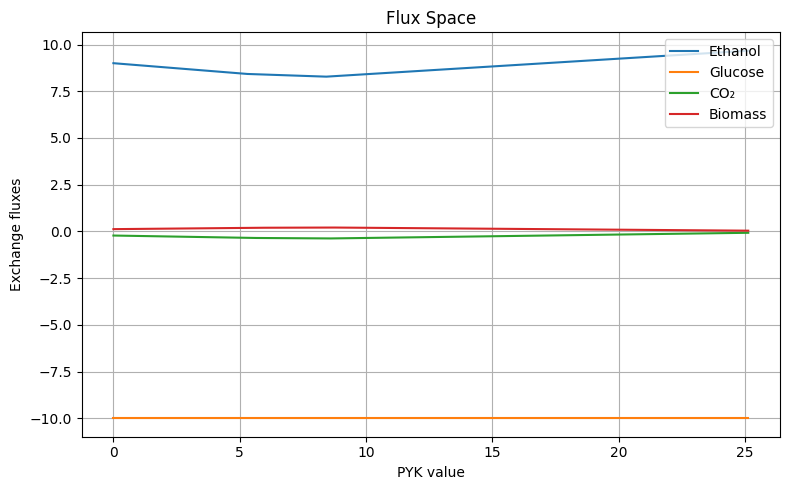

In [15]:
plotting.plot_flux_space(
    X, Y,
    vman_id=vman,
    output_labels=["Ethanol", "Glucose", "CO₂", "Biomass"]
)

## Train Surrogate in PyTorch

In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import surrogateNN

In [17]:
x_scaler, y_scaler, X_train, Y_train, X_val, Y_val, X_test, Y_test = surrogateNN.ML_data_prep(X, Y)
neurons = 4

model_nn = surrogateNN.SurrogateNN(
    input_dim=X_train.shape[1],
    output_dim=Y_train.shape[1],
    hidden_dim=neurons
)

loss_fn=nn.MSELoss()

In [18]:
model_nn, train_losses, val_losses = surrogateNN.train_model(
    model_nn, X_train, Y_train, X_val, Y_val,
    loss_fn=loss_fn, epochs=10000, patience=50
)

Epoch 000 | Train Loss: 0.8364 | Val Loss: 0.8051
Epoch 100 | Train Loss: 0.7160 | Val Loss: 0.6918
Epoch 200 | Train Loss: 0.5791 | Val Loss: 0.5600
Epoch 300 | Train Loss: 0.4260 | Val Loss: 0.4177
Epoch 400 | Train Loss: 0.3136 | Val Loss: 0.3160
Epoch 500 | Train Loss: 0.2457 | Val Loss: 0.2543
Epoch 600 | Train Loss: 0.2042 | Val Loss: 0.2163
Epoch 700 | Train Loss: 0.1779 | Val Loss: 0.1910
Epoch 800 | Train Loss: 0.1604 | Val Loss: 0.1738
Epoch 900 | Train Loss: 0.1476 | Val Loss: 0.1604
Epoch 1000 | Train Loss: 0.1371 | Val Loss: 0.1492
Epoch 1100 | Train Loss: 0.1282 | Val Loss: 0.1396
Epoch 1200 | Train Loss: 0.1204 | Val Loss: 0.1311
Epoch 1300 | Train Loss: 0.1134 | Val Loss: 0.1236
Epoch 1400 | Train Loss: 0.1073 | Val Loss: 0.1169
Epoch 1500 | Train Loss: 0.1018 | Val Loss: 0.1109
Epoch 1600 | Train Loss: 0.0967 | Val Loss: 0.1054
Epoch 1700 | Train Loss: 0.0918 | Val Loss: 0.1000
Epoch 1800 | Train Loss: 0.0868 | Val Loss: 0.0946
Epoch 1900 | Train Loss: 0.0814 | Val Los

In [19]:
from pathlib import Path
import torch



model_filename = f"{vman}_trained_model_input-{X_train.shape[1]}_output-{Y_train.shape[1]}_hidden-{neurons}.pt"
model_path = MODEL_DIR / model_filename
torch.save(model_nn.state_dict(), model_path)


In [20]:
# Rebuild the model architecture (must match original)
model_nn = surrogateNN.SurrogateNN(input_dim=1, hidden_dim=4, output_dim=4)

# Load weights
model_nn.load_state_dict(torch.load(model_path, map_location="cpu"))
model_nn.eval()  # important for inference


SurrogateNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [21]:
# save full model
#torch.save({
#    "model_state": model_nn.state_dict(),
#    "optimizer_state": optimizer.state_dict(),
#    "epoch": epoch,
#    "train_losses": train_losses,
#}, "checkpoint.pth")

#checkpoint = torch.load("checkpoint.pth")
#model_nn.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])

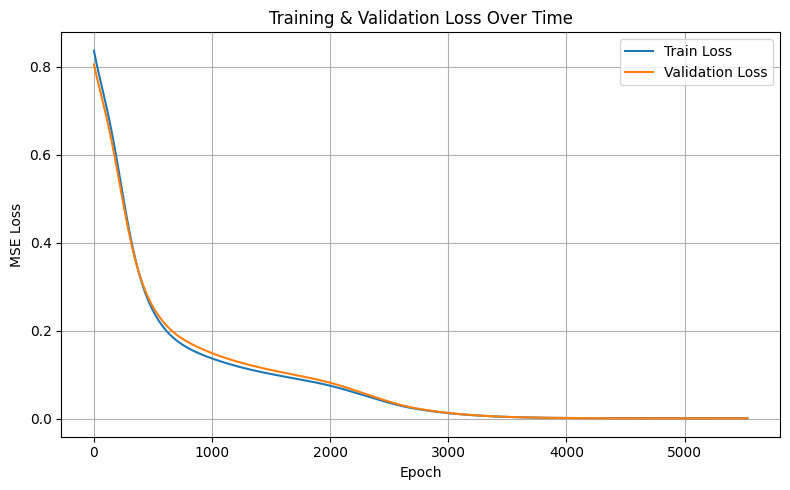

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
model_nn.eval()
with torch.no_grad():
    pred_test = model_nn(X_test)
    loss_test = loss_fn(pred_test, Y_test)

print(f"Final Test MSE: {loss_test.item():.4f}")


Final Test MSE: 0.0020


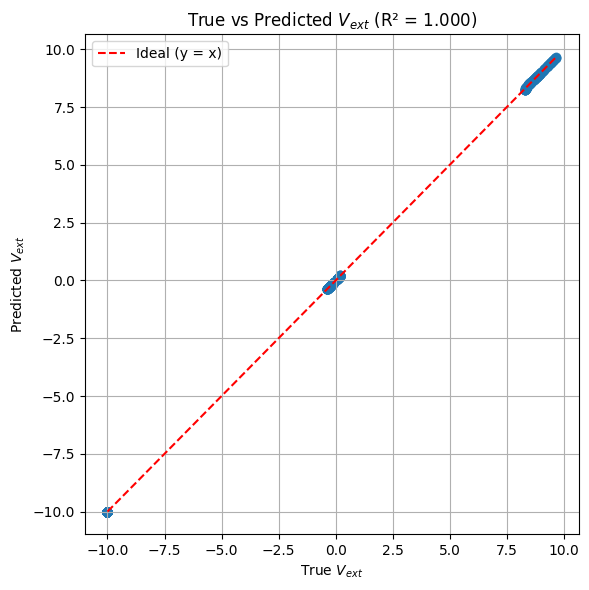

In [24]:
Y_test_np = Y_test.numpy()
pred_test_np = pred_test.numpy()

# Undo scaling
Y_test_true = y_scaler.inverse_transform(Y_test_np)
pred_test_true = y_scaler.inverse_transform(pred_test_np)

# Flatten to plot across all outputs
Y_true_flat = Y_test_true.flatten()
Y_pred_flat = pred_test_true.flatten()

# R² score
r2 = r2_score(Y_true_flat, Y_pred_flat)

# Scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(Y_true_flat, Y_pred_flat, alpha=0.6)
plt.plot([Y_true_flat.min(), Y_true_flat.max()],
         [Y_true_flat.min(), Y_true_flat.max()],
         'r--', label="Ideal (y = x)")
plt.xlabel("True $V_{ext}$")
plt.ylabel("Predicted $V_{ext}$")
plt.title(f"True vs Predicted $V_{{ext}}$ (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
print(Y_test_true.shape)
print(Y_true_flat.shape)


(200, 4)
(800,)


## Build the Hybrid Model

In [26]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import hybrid_model

In [27]:
def vman_func(t):
    return 5.0  # constant PFK flux
    # return 5.0 + 2.0 * np.sin(0.5 * t)  # sinusoidal control

In [28]:
# initial state: [glucose, ethanol, biomass]
z0 = [10.0, 0.0, 0.01]
tspan = (0, 20)
t_eval = np.linspace(tspan[0], tspan[1], 20)

sol = solve_ivp(
    fun=lambda t, z: hybrid_model.hybrid_ode(t, z, vman_func, model_nn, x_scaler, y_scaler),
    t_span=tspan,
    y0=z0,
    t_eval=t_eval,
    method='RK45'
)

rate: 0.009999703608785035, h(z): 0.9999703608785036, biomass: 0.01
rate: 0.009999992728075013, h(z): 0.9999698202940092, biomass: 0.010000294534023872
rate: 0.01000548593519156, h(z): 0.9999595492996295, biomass: 0.010005890680477416
rate: 0.01000838081300755, h(z): 0.9999541365647169, biomass: 0.010008839852786397
rate: 0.01002285894940482, h(z): 0.9999270658832513, biomass: 0.010023590011088929
rate: 0.010025434984499895, h(z): 0.9999222493084955, biomass: 0.010026214529612745
rate: 0.010028655872975406, h(z): 0.9999162270108135, biomass: 0.010029496073841546
rate: 0.010028655821044861, h(z): 0.9999162271079114, biomass: 0.010029496020932727
rate: 0.010086634563059626, h(z): 0.9998078206044588, biomass: 0.010088573378993474
rate: 0.010115996229964378, h(z): 0.9997529212445125, biomass: 0.01011849629543646
rate: 0.010263213114238222, h(z): 0.9994776605216091, biomass: 0.010268576797286332
rate: 0.010289634051588298, h(z): 0.9994282596177531, biomass: 0.010295520416366583
rate: 0.0103

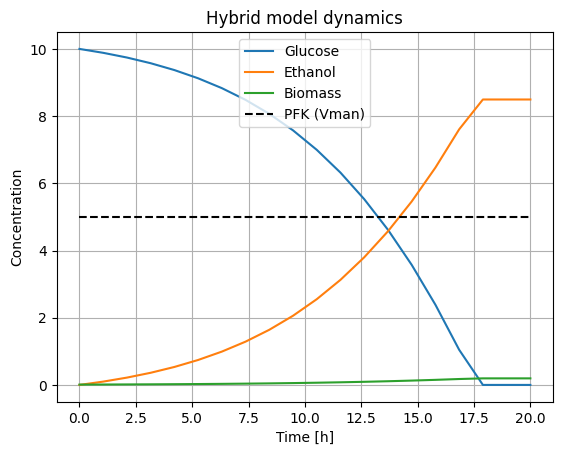

In [29]:
plt.clf()

plt.plot(sol.t, sol.y[0], label='Glucose')
plt.plot(sol.t, sol.y[1], label='Ethanol')
plt.plot(sol.t, sol.y[2], label='Biomass')
vman_values = [vman_func(t) for t in sol.t]
plt.plot(sol.t, vman_values, label='PFK (Vman)', linestyle='--', color='black')
plt.xlabel("Time [h]")
plt.ylabel("Concentration")
plt.title("Hybrid model dynamics")
plt.legend()
plt.grid(True)
plt.show()

## Vman Optimization - doesn't work yet

In [30]:
from optim import optimize_vman
from hybrid_model import hybrid_ode

#define the setup

z0 = [10.0, 0.0, 0.01] # initial state: [glucose, ethanol, biomass]
t_span = (0, 12)
t_eval_points = np.linspace(0, 12, 200)
N = 4
lower, upper = feasible_range
bounds = [(lower, upper)] * N


result, logs = optimize_vman(
    model = model_nn,
    hybrid_ode=hybrid_ode,
    z0=z0,
    t_span=t_span,
    N=N,
    t_eval_points=t_eval_points,
    bounds=bounds,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    log_trajectories=True
)

this statement is new
rate: 0.009999703608785035, h(z): 0.9999703608785036, biomass: 0.01
rate: 0.009999992728075013, h(z): 0.9999698202940092, biomass: 0.010000294534023872
rate: 0.01000548593519156, h(z): 0.9999595492996295, biomass: 0.010005890680477416
rate: 0.01000838081300755, h(z): 0.9999541365647169, biomass: 0.010008839852786397
rate: 0.01002285894940482, h(z): 0.9999270658832513, biomass: 0.010023590011088929
rate: 0.010025434984499895, h(z): 0.9999222493084955, biomass: 0.010026214529612745
rate: 0.010028655872975406, h(z): 0.9999162270108135, biomass: 0.010029496073841546
rate: 0.010028655821044861, h(z): 0.9999162271079114, biomass: 0.010029496020932727
rate: 0.010086634563059626, h(z): 0.9998078206044588, biomass: 0.010088573378993474
rate: 0.010115996229964378, h(z): 0.9997529212445125, biomass: 0.01011849629543646
rate: 0.010263213114238222, h(z): 0.9994776605216091, biomass: 0.010268576797286332
rate: 0.010289634051588298, h(z): 0.9994282596177531, biomass: 0.010295520

Visualize what the optimizer is doing 


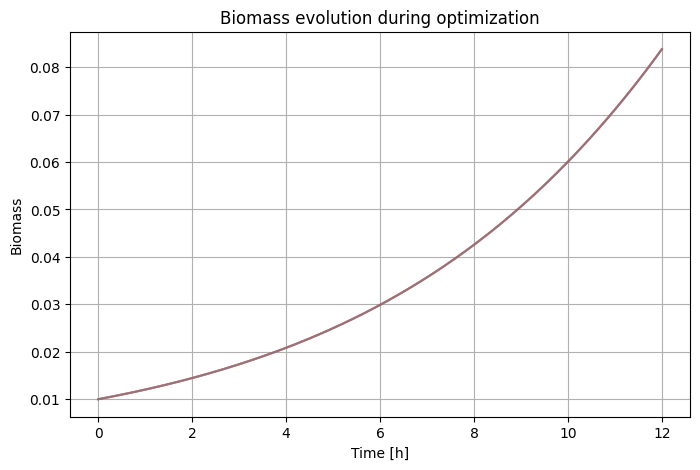

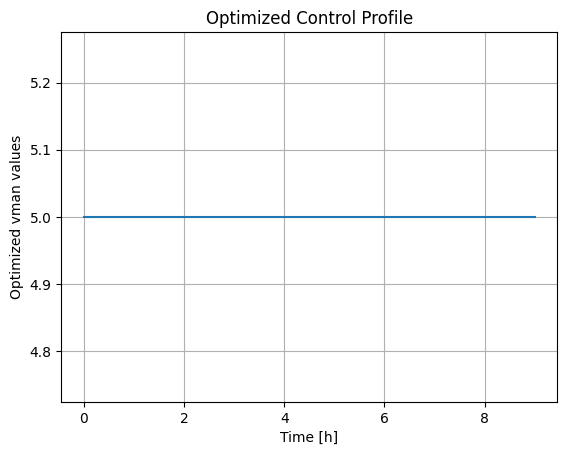

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for entry in logs:
    plt.plot(entry["t"], entry["biomass"], alpha=0.4)
plt.xlabel("Time [h]")
plt.ylabel("Biomass")
plt.title("Biomass evolution during optimization")
plt.grid(True)
plt.show()

# visualize final optimized trajectory
opt_vman_values = result.x
control_times = np.linspace(t_span[0], t_span[1], N + 1)
plt.figure()
plt.step(control_times[:-1], opt_vman_values, where="post")
plt.xlabel("Time [h]")
plt.ylabel("Optimized vman values")
plt.title("Optimized Control Profile")
plt.grid(True)
plt.show()


In [32]:
opt_vman_values = result.x  # optimized control nodes

# Recreate the same time structure used in the optimizer
control_times = np.linspace(t_span[0], t_span[1], N+1)

# Define the time-dependent control function again
def vman_t_opt(t):
    idx = np.searchsorted(control_times, t, side='right') - 1
    idx = np.clip(idx, 0, N - 1)
    return opt_vman_values[idx]

# Re-run the hybrid ODE with optimized control
sol_opt = solve_ivp(
    fun=lambda t, z: hybrid_ode(t, z, vman_t_opt, model_nn, x_scaler, y_scaler),
    t_span=t_span,
    y0=z0,
    t_eval=t_eval_points,
    method='RK45'
)


rate: 0.009999703608785035, h(z): 0.9999703608785036, biomass: 0.01
rate: 0.009999992728075013, h(z): 0.9999698202940092, biomass: 0.010000294534023872
rate: 0.01000548593519156, h(z): 0.9999595492996295, biomass: 0.010005890680477416
rate: 0.01000838081300755, h(z): 0.9999541365647169, biomass: 0.010008839852786397
rate: 0.01002285894940482, h(z): 0.9999270658832513, biomass: 0.010023590011088929
rate: 0.010025434984499895, h(z): 0.9999222493084955, biomass: 0.010026214529612745
rate: 0.010028655872975406, h(z): 0.9999162270108135, biomass: 0.010029496073841546
rate: 0.010028655821044861, h(z): 0.9999162271079114, biomass: 0.010029496020932727
rate: 0.010086634563059626, h(z): 0.9998078206044588, biomass: 0.010088573378993474
rate: 0.010115996229964378, h(z): 0.9997529212445125, biomass: 0.01011849629543646
rate: 0.010263213114238222, h(z): 0.9994776605216091, biomass: 0.010268576797286332
rate: 0.010289634051588298, h(z): 0.9994282596177531, biomass: 0.010295520416366583
rate: 0.0103

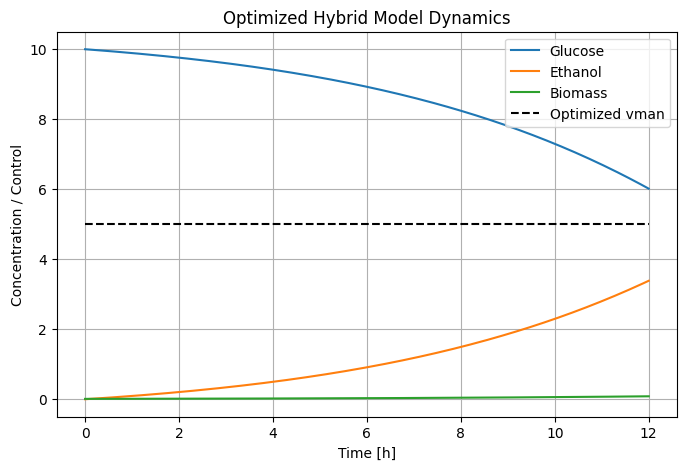

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(sol_opt.t, sol_opt.y[0], label='Glucose')
plt.plot(sol_opt.t, sol_opt.y[1], label='Ethanol')
plt.plot(sol_opt.t, sol_opt.y[2], label='Biomass')

# plot control trajectory
vman_values = [vman_t_opt(t) for t in sol_opt.t]
plt.plot(sol_opt.t, vman_values, '--k', label='Optimized vman')

plt.xlabel('Time [h]')
plt.ylabel('Concentration / Control')
plt.title('Optimized Hybrid Model Dynamics')
plt.legend()
plt.grid(True)
plt.show()
